# A5 Reinforcement Learning for Marble with Variable Goal

For this assignment, start with the `19 Reinforcement Learning Modular Framework` notebook.  Recall that this code used reinforcement learning to learn to push a marble towards the goal position of 5 and keep it there.

(30 points) <font color="red">Modify the code</font> to allow any goal position from 1 to 9.  Modify the agent so that it includes the goal in the state, allowing the agent to learn to push the marble to any given goal.  The objective is an agent that can directly move the marble to a specified goal without any further training. Randomly set the goal to an integer from 1 to 9 at the start of each trial.

(20 points) <font color='red'>Discuss</font> what you modified in the code for this assignment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import neuralnetworks_A4 as nn  # from A4

from IPython.display import display, clear_output

In [2]:
from abc import ABC, abstractmethod


class Environment(ABC):
    def __init__(self, valid_actions):
        self.valid_actions = valid_actions

    @abstractmethod
    def initial_state(self):
        return state  # the initial state

    @abstractmethod
    def next_state(self, state, action):
        return next_state

    @abstractmethod
    def reinforcement(self, state):
        return r  # scalar reinforcement

    def terminal_state(self, state):
        return False  # True if state is terminal state

If abstract methods are not defined in a class derived from `Environment`, we cannot instantiate an instance of that class.

In [3]:
class Marble(Environment):
    def reinforcement(self, state):
        return 1

In [4]:
class Marble(Environment):
    def __init__(self, valid_actions):
        super().__init__(valid_actions)

    def initial_state(self, goal=5):
        return np.array([10 * np.random.uniform(), 0.0, goal])

    def next_state(self, state, action):
        """[0] is position, s[1] is velocity. a is -1, 0 or 1"""
        next_state = state.copy()
        deltaT = 0.1  # Euler integration time step
        next_state[0] += deltaT * state[1]  # Update position
        force = action
        mass = 0.5
        next_state[1] += deltaT * (
            force / mass - 0.2 * state[1]
        )  # Update velocity. Includes friction

        # Bound next position. If at limits, set velocity to 0.
        if next_state[0] < 0:
            next_state = [
                0.0,
                0.0,
                state[2],
            ]  # these constants as ints were causing the errors we discussed in class. I DON'T KNOW WHY!!
        elif next_state[0] > 10:
            next_state = [10.0, 0.0, state[2]]

        return next_state

    def reinforcement(self, state):
        # goal = state[2]
        return 0 if abs(state[0] - state[2]) < 1 else -1

    def terminal_state(self, state):
        return False

In [5]:
marble = Marble(np.array([-1, 0, 1]))

Now we can define an abstract class for a generic `Agent`.

In [6]:
class Agent(ABC):
    def __init__(self, environment):
        self.environment = environment

    @abstractmethod
    def make_samples(self, n_samples, epsilon):
        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i + 1]:
                Qn[i] = self.use(X[i + 1])
        return Qn

    def epsilon_greedy(self, state, epsilon):
        valid_actions = self.environment.valid_actions

        if np.random.uniform() < epsilon:
            # Random Move
            action = np.random.choice(valid_actions)
        else:
            # Greedy Move
            Qs = [
                self.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions
            ]
            ai = np.argmax(Qs)
            action = valid_actions[ai]

        return action

    @abstractmethod
    def train(self):
        return

    @abstractmethod
    def use(self, X):
        return  # Q values for each row of X, each consisting of state and action

In [7]:
class Qnet(Agent):
    def __init__(
        self,
        environment,
        hidden_layers,
        X_means=None,
        X_stds=None,
        Q_means=None,
        Q_stds=None,
    ):
        self.environment = environment

        # assumes state is an np.array, passes in dummy goal
        state_size = environment.initial_state().size
        valid_actions = environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]
        self.Qnet = nn.NeuralNetwork(state_size + action_size, hidden_layers, 1)
        if X_means:
            self.Qnet.X_means = np.array(X_means)
            self.Qnet.X_stds = np.array(X_stds)
            self.Qnet.T_means = np.array(Q_means)
            self.Qnet.T_stds = np.array(Q_stds)

    def make_samples(self, n_samples, epsilon, goal):

        # assumes state is an np.array
        state_size = self.environment.initial_state(goal).size
        valid_actions = self.environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        X = np.zeros((n_samples, state_size + action_size))
        R = np.zeros((n_samples, 1))
        Qn = np.zeros((n_samples, 1))
        terminal_state = np.zeros((n_samples, 1), dtype=bool)  # All False values

        state = self.environment.initial_state(goal)
        state = self.environment.next_state(state, 0)  # Update state, sn from s and a
        action = self.epsilon_greedy(state, epsilon)

        # Collect data from n_samples steps
        for step in range(n_samples):

            next_state = self.environment.next_state(
                state, action
            )  # Update state, sn from s and a
            r = self.environment.reinforcement(
                state
            )  # Calculate resulting reinforcement
            next_action = self.epsilon_greedy(next_state, epsilon)
            X[step, :] = np.hstack((state, action))
            R[step, 0] = r
            if self.environment.terminal_state(state):
                terminal_state[step, 0] = True
                Qn[step, 0] = 0
            else:
                Qn[step, 0] = self.use(np.hstack((next_state, next_action)))
            # Advance one time step
            state, action = next_state, next_action

        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i + 1]:
                Qn[i] = self.use(X[i + 1])
        return Qn

    def train(
        self,
        n_trials,
        n_steps_per_trial,
        n_epochs,
        method,
        learning_rate,
        gamma,
        epsilon,
        final_epsilon,
        trial_callback=None,
    ):

        if trial_callback:
            fig = plt.figure(figsize=(10, 10))

        epsilon_decay = np.exp(
            np.log(final_epsilon) / n_trials
        )  # to produce this final value
        print("epsilon_decay is", epsilon_decay)
        epsilon_trace = np.zeros(n_trials)
        r_trace = np.zeros(n_trials)

        for trial in range(n_trials):
            goal = np.random.uniform(low=1, high=10, size=(1,)).astype(int)
            X, R, Qn, terminal_state = self.make_samples(
                n_steps_per_trial, epsilon, goal[0]
            )

            for epoch in range(n_epochs):
                self.Qnet.train(
                    X,
                    R + gamma * Qn,
                    1,
                    method=method,
                    learning_rate=learning_rate,
                    batch_size=-1,
                    verbose=False,
                )
                self.update_Qn(X, Qn, terminal_state)

            epsilon *= epsilon_decay

            # Rest is for plotting
            epsilon_trace[trial] = epsilon
            r_trace[trial] = np.mean(R)

            if trial_callback and (
                trial + 1 == n_trials or trial % (n_trials / 50) == 0
            ):
                fig.clf()
                trial_callback(agent, trial, n_trials, X, epsilon_trace, r_trace)
                clear_output(wait=True)
                display(fig)

        if trial_callback:
            clear_output(wait=True)

        return epsilon_trace, r_trace

    def use(self, X):
        return self.Qnet.use(X)

In [15]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(
    marble,
    hidden_layers=[20, 15, 5, 5],
    X_means=[5, 0, 0, 5],
    X_stds=[2, 2, 0.8, 1],
    Q_means=[-2],
    Q_stds=[1],
)

plt.ion()

epsilon_trace, r_trace = agent.train(
    n_trials=1000,
    n_steps_per_trial=200,
    n_epochs=500,
    method="sgd",
    learning_rate=0.08,
    gamma=0.9,
    epsilon=1,
    final_epsilon=0.1,
    # trial_callback=plot_status,
)

epsilon_decay is 0.9977000638225533


TODO DICUSSS CHANGES

(20 points) <font color='red'>Add some code</font> at the end of the notebook that applies the trained agent to the marble at goals from 1 to 9.  For each goal, start the marble at positions 0 through 10 with zero velocity and the specified goal and applies the trained agent to control the marble for 200 steps.  Calculate the distance of the final state from the goal.  Average this distance over all starting positions for the specified goal and store in a numpy array with one row for each goal and each row containing the goal and the average of distances to goal over all starting positions. Call this numpy array, `distances_to_goal`.  Plot the results of these average distances versus the goal.

(10 points) <font color='red'>Explore different parameter values</font>, including the network hidden layer structure, number of trials, number of steps per trial, learning rate, number of epochs, and final epsilon value to try to get the best results for `distances_to_goal`.

(20 points) <font color='red'>Discuss</font> the results, and discuss which parameter values seem to perform well.

7.0853483062729055 4.0853483062729055


Text(0.5, 1.0, 'State Trajectories for $\\epsilon=0$')

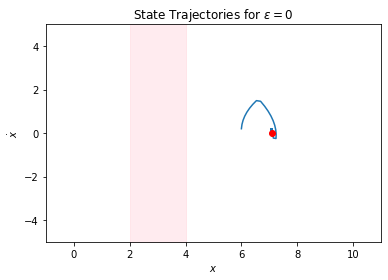

In [17]:
# n_steps_per_trial = 200
# state = [6, 0, 3]  # 0 velocity
# x_trace = np.zeros((n_steps_per_trial, 3))
# for step in range(0, n_steps_per_trial):
#     action = agent.epsilon_greedy(state, 0.0)  # epsilon = 0
#     state = agent.environment.next_state(state, action)
#     x_trace[step, :] = state
# print(state[0], abs(state[0] - state[2]))
# plt.plot(x_trace[:, 0], x_trace[:, 1])
# plt.plot(x_trace[-1, 0], x_trace[-1, 1], "ro")
# plt.fill_between([2, 4], [-5, -5], [5, 5], color="pink", alpha=0.3)
# plt.xlim(-1, 11)
# plt.ylim(-5, 5)
# plt.ylabel("$\dot{x}$")
# plt.xlabel("$x$")
# plt.title("State Trajectories for $\epsilon=0$")

[(1, 5.2727272727272725), (2, 5.633313765440714), (3, 4.4192277803029665), (4, 3.6137254945567885), (5, 2.678112368178064), (6, 3.817086024953619), (7, 3.7590748300564303), (8, 3.770158487473475), (9, 4.382877796986798)]


Text(0.5, 1.0, 'State Trajectories for $\\epsilon=0$')

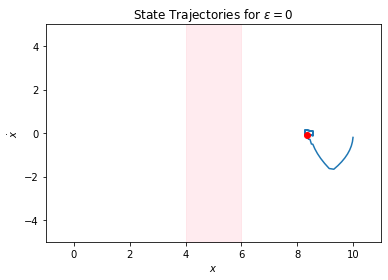

In [18]:
n_steps = 200
distances_to_goal = []
for goal in range(1, 10):
    sum_distance = 0
    for starting_position in range(0, 11):
        state = [starting_position, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps, 3))
        for step in range(0, n_steps):
            action = agent.epsilon_greedy(state, 0.0)  # epsilon = 0
            state = agent.environment.next_state(state, action)
            x_trace[step, :] = state
        sum_distance += abs(state[0] - state[2])
    distances_to_goal.append((goal, sum_distance / 11))
print(distances_to_goal)
plt.plot(x_trace[:, 0], x_trace[:, 1])
plt.plot(x_trace[-1, 0], x_trace[-1, 1], "ro")
plt.fill_between([4, 6], [-5, -5], [5, 5], color="pink", alpha=0.3)
plt.xlim(-1, 11)
plt.ylim(-5, 5)
plt.ylabel("$\dot{x}$")
plt.xlabel("$x$")
plt.title("State Trajectories for $\epsilon=0$")

In [29]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(
    marble,
    hidden_layers=[20, 15, 5, 5],
    X_means=[5, 0, 0, 5],
    X_stds=[2, 2, 0.8, 1],
    Q_means=[-2],
    Q_stds=[1],
)

plt.ion()

epsilon_trace, r_trace = agent.train(
    n_trials=100,
    n_steps_per_trial=200,
    n_epochs=500,
    method="sgd",
    learning_rate=0.01,
    gamma=0.9,
    epsilon=1,
    final_epsilon=0.1,
    # trial_callback=plot_status,
)

epsilon_decay is 0.9772372209558107


[(1, 9.0), (2, 8.0), (3, 7.0), (4, 6.0), (5, 5.0), (6, 4.0), (7, 3.0), (8, 2.0), (9, 1.0)]


Text(0.5, 1.0, 'State Trajectories for $\\epsilon=0$')

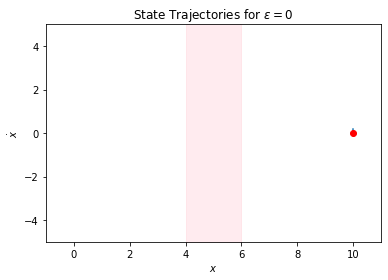

In [30]:
n_steps = 200
distances_to_goal = []
for goal in range(1, 10):
    sum_distance = 0
    for starting_position in range(0, 11):
        state = [starting_position, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps, 3))
        for step in range(0, n_steps):
            action = agent.epsilon_greedy(state, 0.0)  # epsilon = 0
            state = agent.environment.next_state(state, action)
            x_trace[step, :] = state
        sum_distance += abs(state[0] - state[2])
    distances_to_goal.append((goal, sum_distance / 11))
print(distances_to_goal)
plt.plot(x_trace[:, 0], x_trace[:, 1])
plt.plot(x_trace[-1, 0], x_trace[-1, 1], "ro")
plt.fill_between([4, 6], [-5, -5], [5, 5], color="pink", alpha=0.3)
plt.xlim(-1, 11)
plt.ylim(-5, 5)
plt.ylabel("$\dot{x}$")
plt.xlabel("$x$")
plt.title("State Trajectories for $\epsilon=0$")

In [31]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(
    marble,
    hidden_layers=[20, 15, 5, 5],
    X_means=[5, 0, 0, 5],
    X_stds=[2, 2, 0.8, 1],
    Q_means=[-2],
    Q_stds=[1],
)

plt.ion()

epsilon_trace, r_trace = agent.train(
    n_trials=100,
    n_steps_per_trial=200,
    n_epochs=500,
    method="sgd",
    learning_rate=0.005,
    gamma=0.9,
    epsilon=1,
    final_epsilon=0.1,
    # trial_callback=plot_status,
)

epsilon_decay is 0.9772372209558107


[(1, 9.0), (2, 8.0), (3, 7.0), (4, 6.0), (5, 5.0), (6, 4.0), (7, 3.0), (8, 2.0), (9, 1.0)]


Text(0.5, 1.0, 'State Trajectories for $\\epsilon=0$')

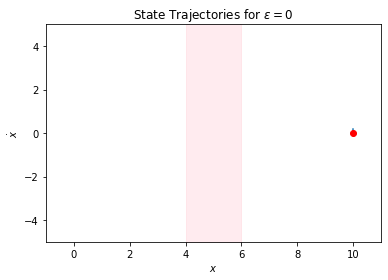

In [32]:
n_steps = 200
distances_to_goal = []
for goal in range(1, 10):
    sum_distance = 0
    for starting_position in range(0, 11):
        state = [starting_position, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps, 3))
        for step in range(0, n_steps):
            action = agent.epsilon_greedy(state, 0.0)  # epsilon = 0
            state = agent.environment.next_state(state, action)
            x_trace[step, :] = state
        sum_distance += abs(state[0] - state[2])
    distances_to_goal.append((goal, sum_distance / 11))
print(distances_to_goal)
plt.plot(x_trace[:, 0], x_trace[:, 1])
plt.plot(x_trace[-1, 0], x_trace[-1, 1], "ro")
plt.fill_between([4, 6], [-5, -5], [5, 5], color="pink", alpha=0.3)
plt.xlim(-1, 11)
plt.ylim(-5, 5)
plt.ylabel("$\dot{x}$")
plt.xlabel("$x$")
plt.title("State Trajectories for $\epsilon=0$")

In [33]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(
    marble,
    hidden_layers=[10, 10],
    X_means=[5, 0, 0, 5],
    X_stds=[2, 2, 0.8, 1],
    Q_means=[-2],
    Q_stds=[1],
)

plt.ion()

epsilon_trace, r_trace = agent.train(
    n_trials=100,
    n_steps_per_trial=200,
    n_epochs=500,
    method="sgd",
    learning_rate=0.02,
    gamma=0.9,
    epsilon=1,
    final_epsilon=0.1,
    # trial_callback=plot_status,
)

epsilon_decay is 0.9772372209558107


[(1, 6.448158586912745), (2, 4.050689889117158), (3, 2.4341761685800978), (4, 0.9502409532185783), (5, 0.5926278642400233), (6, 1.6099158416620234), (7, 2.7797742882003202), (8, 3.6330557655691935), (9, 4.9130306682691165)]


Text(0.5, 1.0, 'State Trajectories for $\\epsilon=0$')

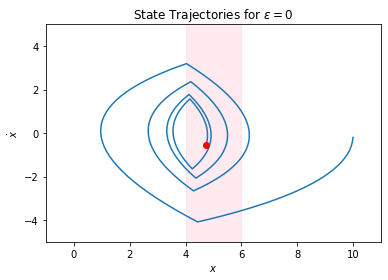

In [34]:
n_steps = 200
distances_to_goal = []
for goal in range(1, 10):
    sum_distance = 0
    for starting_position in range(0, 11):
        state = [starting_position, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps, 3))
        for step in range(0, n_steps):
            action = agent.epsilon_greedy(state, 0.0)  # epsilon = 0
            state = agent.environment.next_state(state, action)
            x_trace[step, :] = state
        sum_distance += abs(state[0] - state[2])
    distances_to_goal.append((goal, sum_distance / 11))
print(distances_to_goal)
plt.plot(x_trace[:, 0], x_trace[:, 1])
plt.plot(x_trace[-1, 0], x_trace[-1, 1], "ro")
plt.fill_between([4, 6], [-5, -5], [5, 5], color="pink", alpha=0.3)
plt.xlim(-1, 11)
plt.ylim(-5, 5)
plt.ylabel("$\dot{x}$")
plt.xlabel("$x$")
plt.title("State Trajectories for $\epsilon=0$")

In [35]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(
    marble,
    hidden_layers=[10, 10],
    X_means=[5, 0, 0, 5],
    X_stds=[2, 2, 0.8, 1],
    Q_means=[-2],
    Q_stds=[1],
)

plt.ion()

epsilon_trace, r_trace = agent.train(
    n_trials=100,
    n_steps_per_trial=200,
    n_epochs=500,
    method="sgd",
    learning_rate=0.05,
    gamma=0.9,
    epsilon=1,
    final_epsilon=0.1,
    # trial_callback=plot_status,
)

epsilon_decay is 0.9772372209558107


[(1, 9.0), (2, 8.0), (3, 7.0), (4, 6.0), (5, 5.0), (6, 4.0), (7, 3.0), (8, 2.0), (9, 1.0)]


Text(0.5, 1.0, 'State Trajectories for $\\epsilon=0$')

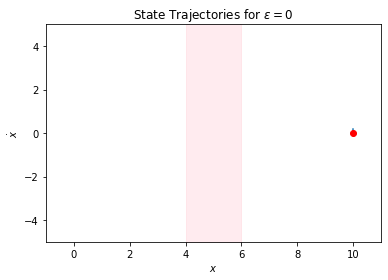

In [36]:
n_steps = 200
distances_to_goal = []
for goal in range(1, 10):
    sum_distance = 0
    for starting_position in range(0, 11):
        state = [starting_position, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps, 3))
        for step in range(0, n_steps):
            action = agent.epsilon_greedy(state, 0.0)  # epsilon = 0
            state = agent.environment.next_state(state, action)
            x_trace[step, :] = state
        sum_distance += abs(state[0] - state[2])
    distances_to_goal.append((goal, sum_distance / 11))
print(distances_to_goal)
plt.plot(x_trace[:, 0], x_trace[:, 1])
plt.plot(x_trace[-1, 0], x_trace[-1, 1], "ro")
plt.fill_between([4, 6], [-5, -5], [5, 5], color="pink", alpha=0.3)
plt.xlim(-1, 11)
plt.ylim(-5, 5)
plt.ylabel("$\dot{x}$")
plt.xlabel("$x$")
plt.title("State Trajectories for $\epsilon=0$")

In [37]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(
    marble,
    hidden_layers=[20, 15, 5, 5],
    X_means=[5, 0, 0, 5],
    X_stds=[2, 2, 0.8, 1],
    Q_means=[-2],
    Q_stds=[1],
)

plt.ion()

epsilon_trace, r_trace = agent.train(
    n_trials=100,
    n_steps_per_trial=200,
    n_epochs=500,
    method="sgd",
    learning_rate=0.02,
    gamma=0.9,
    epsilon=1,
    final_epsilon=0.1,
    # trial_callback=plot_status,
)

epsilon_decay is 0.9772372209558107


[(1, 8.272727272727273), (2, 5.036925352617309), (3, 2.7213803439854027), (4, 3.3002125625550076), (5, 4.437498106828461), (6, 4.909090909090909), (7, 4.818181818181818), (8, 4.363636363636363), (9, 4.545454545454546)]


Text(0.5, 1.0, 'State Trajectories for $\\epsilon=0$')

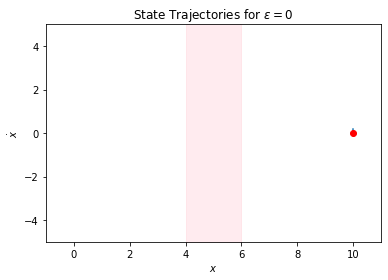

In [38]:
n_steps = 200
distances_to_goal = []
for goal in range(1, 10):
    sum_distance = 0
    for starting_position in range(0, 11):
        state = [starting_position, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps, 3))
        for step in range(0, n_steps):
            action = agent.epsilon_greedy(state, 0.0)  # epsilon = 0
            state = agent.environment.next_state(state, action)
            x_trace[step, :] = state
        sum_distance += abs(state[0] - state[2])
    distances_to_goal.append((goal, sum_distance / 11))
print(distances_to_goal)
plt.plot(x_trace[:, 0], x_trace[:, 1])
plt.plot(x_trace[-1, 0], x_trace[-1, 1], "ro")
plt.fill_between([4, 6], [-5, -5], [5, 5], color="pink", alpha=0.3)
plt.xlim(-1, 11)
plt.ylim(-5, 5)
plt.ylabel("$\dot{x}$")
plt.xlabel("$x$")
plt.title("State Trajectories for $\epsilon=0$")

In [44]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(
    marble,
    hidden_layers=[10, 10],
    X_means=[5, 0, 0, 5],
    X_stds=[2, 2, 0.8, 1],
    Q_means=[-2],
    Q_stds=[1],
)

plt.ion()

epsilon_trace, r_trace = agent.train(
    n_trials=100,
    n_steps_per_trial=200,
    n_epochs=500,
    method="sgd",
    learning_rate=0.02,
    gamma=0.9,
    epsilon=1,
    final_epsilon=0.1,
    # trial_callback=plot_status,
)

epsilon_decay is 0.9772372209558107


[(1, 7.367398808070484), (2, 3.5725496313917735), (3, 1.9234532876589712), (4, 0.79097361553305), (5, 0.512551133790269), (6, 1.3836014320559615), (7, 2.0086405112533314), (8, 2.66853230453242), (9, 3.014603574556747)]


Text(0.5, 1.0, 'State Trajectories for $\\epsilon=0$')

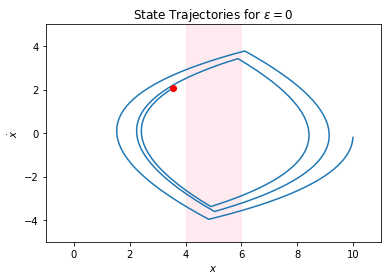

In [45]:
n_steps = 200
distances_to_goal = []
for goal in range(1, 10):
    sum_distance = 0
    for starting_position in range(0, 11):
        state = [starting_position, 0, goal]  # 0 velocity
        x_trace = np.zeros((n_steps, 3))
        for step in range(0, n_steps):
            action = agent.epsilon_greedy(state, 0.0)  # epsilon = 0
            state = agent.environment.next_state(state, action)
            x_trace[step, :] = state
        sum_distance += abs(state[0] - state[2])
    distances_to_goal.append((goal, sum_distance / 11))
print(distances_to_goal)
plt.plot(x_trace[:, 0], x_trace[:, 1])
plt.plot(x_trace[-1, 0], x_trace[-1, 1], "ro")
plt.fill_between([4, 6], [-5, -5], [5, 5], color="pink", alpha=0.3)
plt.xlim(-1, 11)
plt.ylim(-5, 5)
plt.ylabel("$\dot{x}$")
plt.xlabel("$x$")
plt.title("State Trajectories for $\epsilon=0$")

Your solution to this assignment will not be automatically graded.  Instead, the grade will only depend on your successful modifications to the code and your discussions.

## Extra Credit

Receive 1 point of extra credit for each of these:

   * Modify your solution to this assignment by creating and using a `Marble2D` class that simulates the marble moving in two-dimensions, on a plane.  Some of the current plots will not work for this case. Just show the ones that are still appropriate.
   * Experiment with seven valid actions rather than three.  How does this change the behavior of the controlled marble?